# Plot cluster tracks and contingency matrix

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load track portion

In [9]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [10]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_main)
    df_cluster_7.append(df_sel)

In [11]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [12]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [13]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [14]:
CLUSTER_STR_7 = ["Straight", "Curved-1", "Curved-2", "Straight", "Curved-1", "Curved-2"]

## Contingency matrix

In [15]:
TARGET_ANGLE_STR = ["TC1", "TC2", "TC3", "TC4", "CT1", "CT2", "CT3", "CT4"]

In [16]:
# Build contingency matrix
df_tca_all = []
# cluster_num = [0, 1, 2, 4, 6, 5]

# create the first entry to ensure properly TCA sequence
df_tca_all.append(pd.DataFrame(columns=TARGET_ANGLE_STR).T)

# tally from all clusters
for df, cnum in zip(df_cluster_clean_7, new_seq):
    for tca in TARGET_ANGLE_STR:
        df_tca = df["TARGET_ANGLE"].value_counts()
    df_tca.name = "cluster" + str(cnum)
    df_tca_all.append(df_tca)
df_tca_all = pd.concat(df_tca_all, axis=1)

df_tca_all

,cluster0,cluster2,cluster1,cluster6,cluster4,cluster3
TC1,7.0,4.0,1.0,NaN,NaN,NaN
TC2,5.0,3.0,NaN,NaN,NaN,NaN
TC3,3.0,2.0,5.0,NaN,NaN,NaN
TC4,1.0,7.0,3.0,NaN,NaN,NaN
CT1,NaN,NaN,NaN,4.0,2.0,NaN
CT2,NaN,NaN,NaN,2.0,2.0,4.0
CT3,NaN,NaN,NaN,8.0,1.0,1.0
CT4,NaN,NaN,NaN,9.0,3.0,1.0


In [17]:
xtick_str = [
    "%s\n(%d)" % (tca_str, tca_num) 
    for tca_num, tca_str in zip(df_tca_all.sum(axis=1).values, TARGET_ANGLE_STR)
]
xtick_str

['TC1\n(12)',
 'TC2\n(8)',
 'TC3\n(10)',
 'TC4\n(11)',
 'CT1\n(6)',
 'CT2\n(8)',
 'CT3\n(10)',
 'CT4\n(13)']

In [18]:
TCCT_STR = np.array(["TC", "CT"]*3).reshape(3,2).T.reshape(-1,1).T.squeeze().tolist()
ytick_str = [
    "%s-%s (%d)     " % (tcct, c_name, tca_num)
    for tca_num, c_name, tcct in zip(
        df_tca_all.sum(axis=0).values, CLUSTER_STR_7, TCCT_STR
    )
]
ytick_str

['TC-Straight (16)     ',
 'TC-Curved-1 (16)     ',
 'TC-Curved-2 (9)     ',
 'CT-Straight (23)     ',
 'CT-Curved-1 (8)     ',
 'CT-Curved-2 (6)     ']

In [19]:
# Position of number of trials in each cell
text_pos_x = np.arange(0, 7.5, 1)
text_pos_y = np.arange(0, 5.5, 1)
text_pos_x, text_pos_y

(array([0., 1., 2., 3., 4., 5., 6., 7.]), array([0., 1., 2., 3., 4., 5.]))

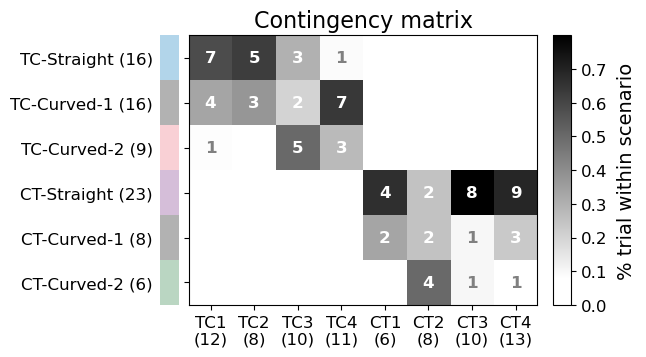

In [20]:
fig,ax_conti = plt.subplots(1, 1, figsize=(4.5, 3.5))

im = ax_conti.imshow(
    (df_tca_all.values / np.expand_dims(df_tca_all.sum(axis=1).values, axis=1)).T,
    aspect='auto', cmap="gist_yarg" #"Reds" #"OrRd" 
)
ax_conti.set_xticks(np.arange(len(TARGET_ANGLE_STR)))
ax_conti.set_xticklabels(xtick_str, fontsize=12)
ax_conti.set_yticks(np.arange(len(ytick_str)))
ax_conti.set_yticklabels(ytick_str, fontsize=12)
# ax_conti.yaxis.tick_right()
# ax_conti.axis('equal')
ax_conti.set_xlim(-0.5, 7.5)
ax_conti.set_ylim(5.5, -0.5)
ax_conti.set_title("Contingency matrix", fontsize=16)

# Add numbers in square
for row in np.arange(df_tca_all.shape[0]):
    for col in np.arange(df_tca_all.shape[1])[::-1]:
        val = df_tca_all.values[row, col]
        if ~np.isnan(val):
            text_color = "gray" if val==1 else "w"
            ax_conti.text(text_pos_x[row], text_pos_y[col],
                          val.astype(int), color=text_color,
                          va="center", ha="center", fontsize=12, fontweight="bold")

# Add color code for vertical axis
ax_conti_pos = ax_conti.get_position()
ax_add = fig.add_axes([ax_conti_pos.x0-0.065, ax_conti_pos.y0, 0.045, ax_conti_pos.height])
ax_add.set_xticks([])
ax_add.set_yticks([])
for seq, color in enumerate(color_cluster_seq_7):
    ax_add.bar(0, height=1, bottom=seq-0.5, color=color, alpha=0.3)
ax_add.set_ylim(-0.5, 5.5)
ax_add.invert_yaxis()
ax_add.axis("off")

# Add colorbar
ax_cbar = fig.add_axes([ax_conti_pos.x0+0.81, ax_conti_pos.y0, 0.04, ax_conti_pos.height])
cbar = plt.colorbar(im, cax=ax_cbar, orientation="vertical")
cbar.ax.set_ylabel("% trial within scenario", fontsize=14, labelpad=7)
cbar.ax.set_yticks(np.arange(0, 0.8, 0.1))
cbar.ax.set_yticklabels(["%.1f" % n for n in np.arange(0, 0.8, 0.1)], fontsize=12)


plt.show()


# # Save figure
# fig.savefig(fig_path / "fig_contingency_matrix.png", dpi=300, bbox_inches="tight")

## Cluster tracks

In [21]:
def plot_track(axx, df, color, alpha=0.1, lw=2):
    axx.plot(
        df[df["before_touch"]]["DTAG_X"],
        df[df["before_touch"]]["DTAG_Y"],
        alpha=alpha, color=color, lw=lw
    )

In [22]:
## Get ellipse

half_foci = 0.5
r_major = 7/2
r_minor = np.sqrt(r_major**2 - half_foci**2)

# Used for plotting ellipse
t = np.linspace(0, 2*np.pi, 100)

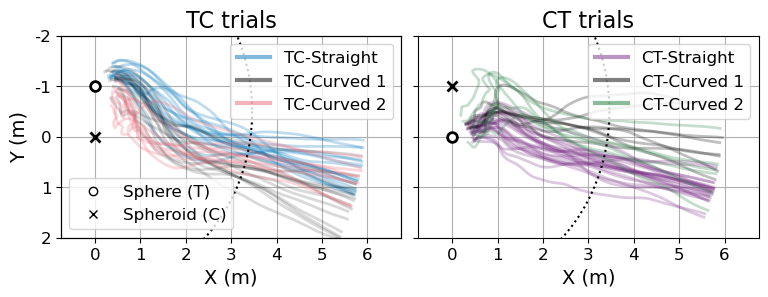

In [23]:
fig = plt.figure(figsize=(9, 3.5), facecolor="w")

gs = fig.add_gridspec(1, 2)

plt.subplots_adjust(hspace=0.3, wspace=0.05)


# Track overlay
# ===================================
ax_track_TC = fig.add_subplot(gs[0, 0])
# ===================================
for seq in np.arange(3):
    for trial_idx in df_cluster_clean_7[seq].index:
        df_track = df_track_portion_all[trial_idx]
        alpha=0.15 if seq==1 else 0.25
        plot_track(
            ax_track_TC, df_track,
            color=color_cluster_seq_7[seq], alpha=alpha, lw=2
        )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=2, markersize=7, lw=1.5)
ax_track_TC.plot(0, -1, "ko", markeredgewidth=2, markersize=7, lw=1.5, markerfacecolor="w")

# ===================================
ax_track_CT = fig.add_subplot(gs[0, 1])
# ===================================
for seq in np.arange(3) + 3:
    for trial_idx in df_cluster_clean_7[seq].index:
        df_track = df_track_portion_all[trial_idx]
        alpha=0.15 if seq==1 else 0.25
        plot_track(
            ax_track_CT, df_track,
            color=color_cluster_seq_7[seq], alpha=alpha, lw=2
        )
ax_track_CT.plot(0, -1, "kx", markeredgewidth=2, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=2, markersize=7, markerfacecolor="w")

for axx in [ax_track_TC, ax_track_CT]:
    axx.set_xticks(np.arange(-1, 9))
    axx.set_xticklabels(np.arange(-1, 9), fontsize=12)
    axx.set_ylim(2, -2)
    axx.set_xlim(-0.75, 6.75)
    axx.grid()
    axx.set_xlabel("X (m)", fontsize=14)
    axx.set_yticks(np.arange(-2, 3))
ax_track_TC.set_yticklabels(np.arange(-2, 3), fontsize=12)
ax_track_TC.set_ylabel("Y (m)", fontsize=14)
ax_track_CT.set_yticklabels("")

# Add legend for cluster tracks
ax_track_TC.set_title("TC trials", fontsize=16)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_straight"], label="TC-Straight", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved1"], label="TC-Curved 1", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved2"], label="TC-Curved 2", alpha=0.5, lw=3)
ax_track_TC.legend(fontsize=12, loc="upper right")

ax_track_CT.set_title("CT trials", fontsize=16)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_straight"], label="CT-Straight", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved1"], label="CT-Curved 1", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved2"], label="CT-Curved 2", alpha=0.5, lw=3)
ax_track_CT.legend(fontsize=12, loc="upper right")

# Adjust size of track panels
axx = ax_track_TC
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0+axx_pos.height*0.1, axx_pos.width, axx_pos.height*0.75
])
axx = ax_track_CT
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0+axx_pos.height*0.1, axx_pos.width, axx_pos.height*0.75
])

# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.set_position(ax_track_TC.get_position())
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (T)", markerfacecolor="w")
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (C)")
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=12, loc="lower left")




# ===================================
# Plot ellipse
# ===================================a
ax_track_TC.plot(r_minor*np.cos(t) , -0.5+r_major*np.sin(t), lw=1.5, color="k", ls=":")
ax_track_CT.plot(r_minor*np.cos(t) , -0.5+r_major*np.sin(t), lw=1.5, color="k", ls=":")


plt.show()



# # Save figure
# fig.savefig(fig_path / "fig_cluster_tracks.png", dpi=300, bbox_inches="tight")

## Put panels together

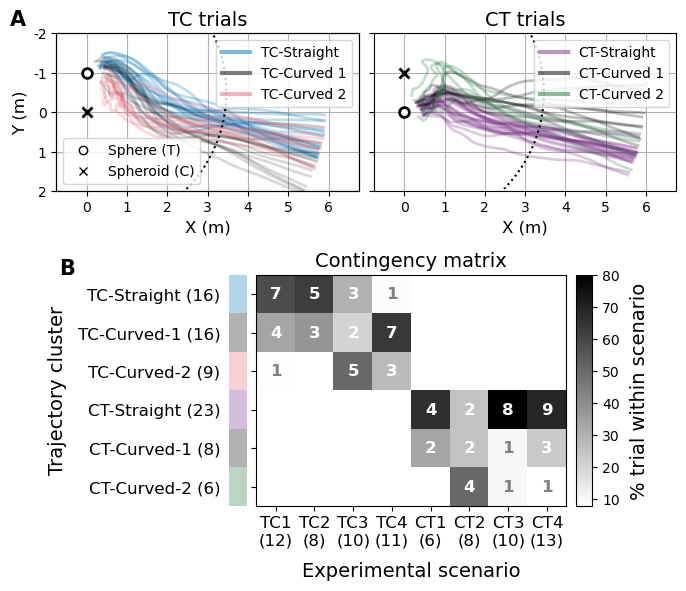

In [24]:
fig = plt.figure(figsize=(8, 6), facecolor="w")

gs = fig.add_gridspec(2, 2)

plt.subplots_adjust(wspace=0.05)


# Track overlay
# ===================================
ax_track_TC = fig.add_subplot(gs[0, 0])
# ===================================
for seq in np.arange(3):
    for trial_idx in df_cluster_clean_7[seq].index:
        df_track = df_track_portion_all[trial_idx]
        alpha=0.15 if seq==1 else 0.25
        plot_track(
            ax_track_TC, df_track,
            color=color_cluster_seq_7[seq], alpha=alpha, lw=2
        )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=2, markersize=7, lw=1.5)
ax_track_TC.plot(0, -1, "ko", markeredgewidth=2, markersize=7, lw=1.5, markerfacecolor="w")

# ===================================
ax_track_CT = fig.add_subplot(gs[0, 1])
# ===================================
for seq in np.arange(3) + 3:
    for trial_idx in df_cluster_clean_7[seq].index:
        df_track = df_track_portion_all[trial_idx]
        alpha=0.15 if seq==1 else 0.25
        plot_track(
            ax_track_CT, df_track,
            color=color_cluster_seq_7[seq], alpha=alpha, lw=2
        )
ax_track_CT.plot(0, -1, "kx", markeredgewidth=2, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=2, markersize=7, markerfacecolor="w")

for axx in [ax_track_TC, ax_track_CT]:
    axx.set_xticks(np.arange(-1, 9))
    axx.set_xticklabels(np.arange(-1, 9), fontsize=10)
    axx.set_ylim(2, -2)
    axx.set_xlim(-0.75, 6.75)
    axx.grid()
    axx.set_xlabel("X (m)", fontsize=12)
    axx.set_yticks(np.arange(-2, 3))
ax_track_TC.set_yticklabels(np.arange(-2, 3), fontsize=10)
ax_track_TC.set_ylabel("Y (m)", fontsize=12)
ax_track_CT.set_yticklabels("")

# Add legend for cluster tracks
ax_track_TC.set_title("TC trials", fontsize=14)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_straight"], label="TC-Straight", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved1"], label="TC-Curved 1", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved2"], label="TC-Curved 2", alpha=0.5, lw=3)
ax_track_TC.legend(fontsize=10, loc="upper right")

ax_track_CT.set_title("CT trials", fontsize=14)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_straight"], label="CT-Straight", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved1"], label="CT-Curved 1", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved2"], label="CT-Curved 2", alpha=0.5, lw=3)
ax_track_CT.legend(fontsize=10, loc="upper right")

# Adjust size of track panels
axx = ax_track_TC
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0+axx_pos.height*0.1, axx_pos.width, axx_pos.height*0.75
])
axx = ax_track_CT
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0+axx_pos.height*0.1, axx_pos.width, axx_pos.height*0.75
])

# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.set_position(ax_track_TC.get_position())
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (T)", markerfacecolor="w")
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (C)")
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=10, loc="lower left")




# ===================================
# Plot ellipse
# ===================================a
ax_track_TC.plot(r_minor*np.cos(t) , -0.5+r_major*np.sin(t), lw=1.5, color="k", ls=":")
ax_track_CT.plot(r_minor*np.cos(t) , -0.5+r_major*np.sin(t), lw=1.5, color="k", ls=":")




# Contingency matrix
# ===================================
ax_conti = fig.add_subplot(gs[1, :])
# ===================================

im = ax_conti.imshow(
    (df_tca_all.values / np.expand_dims(df_tca_all.sum(axis=1).values, axis=1) * 100).T,
    aspect='auto', cmap="gist_yarg" #"Reds" #"OrRd" 
)
ax_conti.set_xticks(np.arange(len(TARGET_ANGLE_STR)))
ax_conti.set_xticklabels(xtick_str, fontsize=12)
ax_conti.set_xlabel("Experimental scenario", fontsize=14, labelpad=10)
ax_conti.set_yticks(np.arange(len(ytick_str)))
ax_conti.set_yticklabels(ytick_str, fontsize=12)
ax_conti.set_ylabel("Trajectory cluster", fontsize=14, labelpad=7.5)
ax_conti.set_xlim(-0.5, 7.5)
ax_conti.set_ylim(5.5, -0.5)
ax_conti.set_title("Contingency matrix", fontsize=14)

# Add numbers in square
for row in np.arange(df_tca_all.shape[0]):
    for col in np.arange(df_tca_all.shape[1])[::-1]:
        val = df_tca_all.values[row, col]
        if ~np.isnan(val):
            text_color = "gray" if val==1 else "w"
            ax_conti.text(text_pos_x[row], text_pos_y[col],
                          val.astype(int), color=text_color,
                          va="center", ha="center", fontsize=12, fontweight="bold")

# Move and shrink axis
ax_pos = ax_conti.get_position()
ax_conti.set_position(
    [ax_pos.x0+0.25, ax_pos.y0-0.07, ax_pos.width*0.5, ax_pos.height*1.1]
)

# Add color code for vertical axis
ax_conti_pos = ax_conti.get_position()
ax_add = fig.add_axes([ax_conti_pos.x0-0.035, ax_conti_pos.y0, 0.025, ax_conti_pos.height])
ax_add.set_xticks([])
ax_add.set_yticks([])
for seq, color in enumerate(color_cluster_seq_7):
    ax_add.bar(0, height=1, bottom=seq-0.5, color=color, alpha=0.3)
ax_add.set_ylim(-0.5, 5.5)
ax_add.invert_yaxis()
ax_add.axis("off")

# Add colorbar
ax_cbar = fig.add_axes([ax_conti_pos.x0+0.4, ax_conti_pos.y0, 0.02, ax_conti_pos.height])
cbar = plt.colorbar(im, cax=ax_cbar, orientation="vertical")
cbar.ax.set_ylabel("% trial within scenario", fontsize=14, labelpad=7)



# Add panel labels
ax_track_TC.text(-1.9, -2.2, "A", fontsize=15, fontweight="bold")
ax_conti.text(-5.6, -0.5, "B", fontsize=15, fontweight="bold")



plt.show()


# Save figure
fig.savefig(fig_path / "fig_cluster_tracks_contingency.png", dpi=300, bbox_inches="tight")
